In [1]:
%cd ..
%ls 

from ch_est_net.preloading import *
from ch_est_net.Net import Net
from ch_est_net.criterion import MSE_detector_loss
from ch_est_net.Trainer import Trainer

%load_ext autoreload
%autoreload 2

/home/alex/GitHub/ML_for_channel_estimation
ch_est_net/        config.yaml  DMRS_signal/  __pycache__/  requirements.txt
config_beams.yaml  data.h5      Notebooks/    README.md


In [2]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


/home/alex/GitHub/ML_for_channel_estimation/ch_est_net/preloading.py:91: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:578.)
  h_ifft = torch.ifft(h_f_rolled, signal_ndim=1, normalized=True)


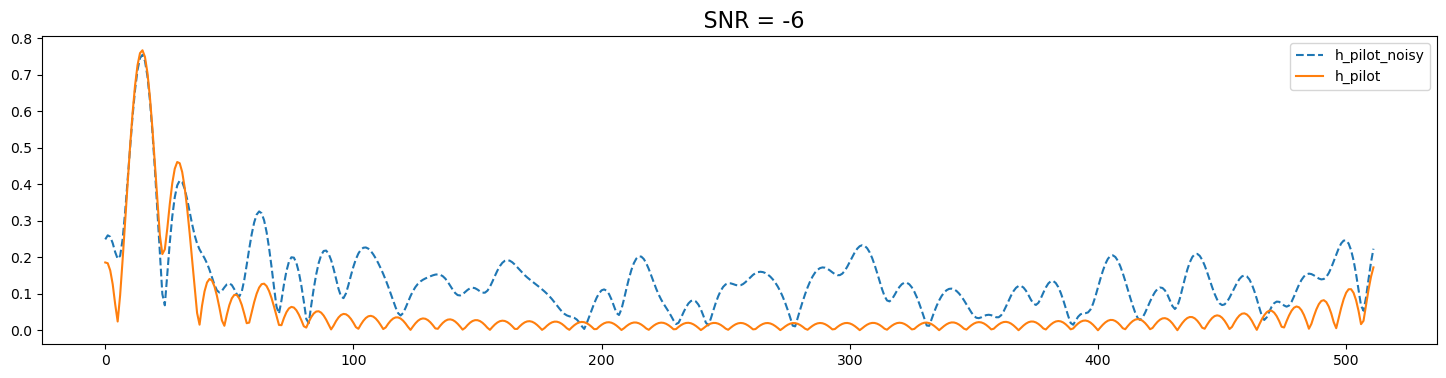

In [3]:
n_subc = 48 # число поднесущих
N_t = 64 # число приемных антенн
n_samples = 512 # кол-во отсчетов импульсной и частотной характеристики
ind = 85
SNR = -6 
seed = 5

h_pilot, h_data = data_load(scen0, dtype =dtype, onePilotFolder=onePilotFolder, dataL = dataL, ind=ind) # комплексные частотные характеристики для пилотных и информационных символов
h_pilot_noisy, _ = add_noise(h_pilot, SNR = SNR,scen = scen0,dtype=dtype, seed=seed) # получаем зашумленный пилот
h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = SNR,dtype=dtype, seed = seed)

h_ideal = h_pilot.mean(dim=2)
u = h_pilot_noisy.mean(dim=2)


plt.style.use('default')
plt.figure(figsize = (18,4))
plt.title('    SNR = ' +str(SNR), fontsize=16)
  # noizy h_pilot in freq domain -> time domain -> sqrt(re^2 + im^2)
u_print = ((upsampling(scen0, h = u[:,0:n_subc,:], inverse = False)**2)[:,:,0] + (upsampling(scen0, h = u[:,0:n_subc,:], inverse = False)**2)[:,:,1])**0.5
plt.plot(u_print[0,:], "--", label = 'h_pilot_noisy')
  # clear h_pilot in freq domain -> time domain -> sqrt(re^2 + im^2)
h_print = ((upsampling(scen0, h = h_pilot.mean(dim=2)[:,0:n_subc,:], inverse = False)**2)[:,:,0] + (upsampling(scen0, h = h_pilot.mean(dim=2)[:,0:n_subc,:], inverse = False)**2)[:,:,1])**0.5
plt.plot(h_print[0,:], label = 'h_pilot')
plt.legend()
plt.show()

In [4]:

scen = Scenario(SNR=0, seed=0,  RB_num = 4, index=1, beam_transform = 0, N_ports = 16,
                    N_TTI=1, UE_indx=0, UE_number=1, N_seeds=4, N_scenarios=140, RB_size=12, N_pilot=2, Nrx=64,
                    upsample_factor=1, Nfft=512, N_shift=10, N_response=448*512//2048, comb = 0)

with open('config.yaml') as file:
    cfg = yaml.load(file, Loader = yaml.FullLoader)
cfg = Namespace(**dict(cfg))

net = Net(cfg)
optimizer = torch.optim.Adam(net.parameters() , lr = 1.0e-2 )
criterion = MSE_detector_loss
trainer = Trainer(net, cfg, optimizer, criterion)
trainer.train_with_scenary(u, h_data_noisy, data_noise_power, scen)

Created Net with  8 layers

 Stage  0
round =  0 , loss =  0.599608
round =  0 , loss =  0.513051
round =  0 , loss =  0.418561
round =  0 , loss =  0.32475
round =  0 , loss =  0.241093
round =  0 , loss =  0.175253
round =  0 , loss =  0.130484
round =  0 , loss =  0.104932
round =  0 , loss =  0.093342
round =  0 , loss =  0.089808
round =  0 , loss =  0.089743
round =  0 , loss =  0.090475
round =  0 , loss =  0.090894
round =  0 , loss =  0.090819
round =  0 , loss =  0.090454
round =  0 , loss =  0.090048
round =  0 , loss =  0.089753
round =  0 , loss =  0.089601
round =  0 , loss =  0.089554
round =  0 , loss =  0.089556
round =  0 , loss =  0.089567
round =  0 , loss =  0.089571
round =  0 , loss =  0.089566
round =  0 , loss =  0.08956
round =  0 , loss =  0.089555
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
round =  0 , loss =  0.089552
roun

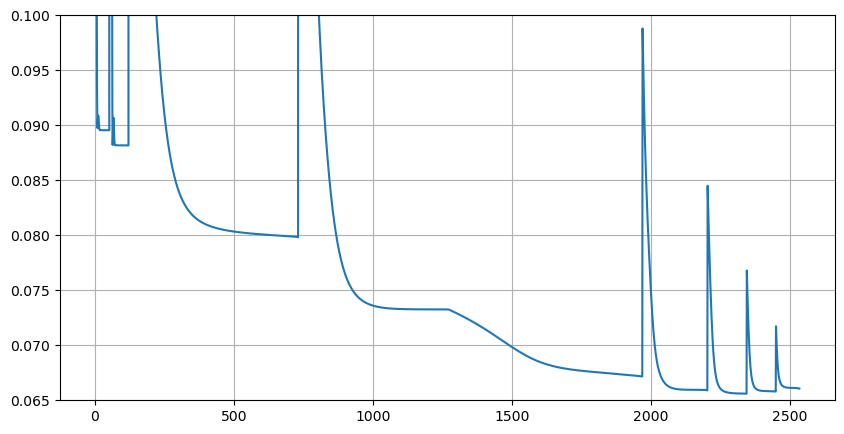

In [30]:
plt.figure(figsize=(10,5))
plt.plot(trainer.loss_history)
plt.ylim([0.065,0.1])
#plt.yscale('log')
plt.grid()


In [19]:

'''Функция предсказания. Прогоняет данные для всех указанных SNR и файлов'''
def preds(NET = net, ml = ml_default, 
            lossVersion='detector', # 'detector' or 'relError'
            inds=range(1,141), 
            SNR_L=range(-10,-1), 
            seed=4, 
            max_iter=3, 
            ml_version=12, 
            SNRscaleFactor=1.,
            scen=scen0, scale=True):
    assert lossVersion in ['detector', 'relError']
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb

    z = torch.zeros(64, 512, 2, requires_grad = False)
    h_hat = torch.zeros(64, 512, 2, requires_grad = False) 

    losses = []

    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, dtype =dtype, onePilotFolder=onePilotFolder, dataL= dataL, ind=ind+1 ,use_preloaded = False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, scen =scen, dtype = dtype,seed=seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR, dtype = dtype, seed=seed) 
                

                u = h_pilot_noisy.mean(dim=2)


                # CHANNEL ESTIMATION # оценка канала 
                preds = NET.forward(u = u)
                h_pilot_rec = preds[:,:n_subc,:]
                
                # Show time domain recovered and initial signals
                if ind % 70==-1:
                    h_pilot_rec_numpy = upsampling(scen, h_pilot_rec, inverse=False).detach().numpy()
                    plt.plot(h_pilot_rec_numpy[0,:,0]**2+h_pilot_rec_numpy[0,:,1]**2)
                    h_f = h_pilot
                    if len(h_f.shape) == 4:
                        h_f = h_f.mean(dim=2)
                    h_f = upsampling(scen, h_f, inverse=False).detach().numpy()
                    plt.plot(h_f[0,:,0]**2+h_f[0,:,1]**2)
                    plt.show()            
                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)

                cur = {'loss': err_data.detach().numpy() ,'SNR': SNR, 'file': ind}
                losses.append(cur)

            loss.append(loss_current)        
            
    return loss, losses

In [20]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range =range(1, 140, 2)
detector_error_beam_net, losses = preds(NET = net, 
            inds=scenario_range,
            scen = scen,
            SNR_L=SNR_range)

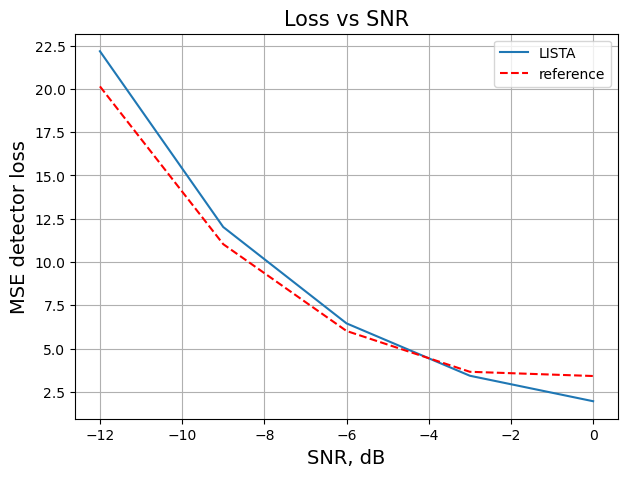

In [27]:
import matplotlib.pyplot as plt
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
plt.style.use("default")
plt.figure(figsize=(7,5))
# plt.plot(SNR_range, detector_error_net, SNR_range, detector_error_beam_net, '.-', label = 'Net', color='r')
plt.plot(SNR_range,detector_error_beam_net )
plt.plot(SNR_range,reference, '--r')
plt.legend(["LISTA", "reference"])
plt.title("Loss vs SNR", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.grid()
# plt.legend()
plt.show()